# Online_retail_II
data was downloaded here: https://archive.ics.uci.edu/ml/datasets/Online+Retail+II, 
https://archive.ics.uci.edu/ml/datasets/online+retail

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (12, 5)

import seaborn as sns
%matplotlib inline

In [2]:
%time df_1 = pd.read_excel(r'..\input_data\online_retail_I.xlsx')
%time df_2 = pd.read_excel(r'..\input_data\online_retail_II.xlsx')

Wall time: 52.2 s
Wall time: 1min 31s


In [3]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
Invoice        525461 non-null object
StockCode      525461 non-null object
Description    522533 non-null object
Quantity       525461 non-null int64
InvoiceDate    525461 non-null datetime64[ns]
Price          525461 non-null float64
Customer ID    417534 non-null float64
Country        525461 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [5]:
df_1.shape

(541909, 8)

In [6]:
df_2.shape

(525461, 8)

In [7]:
df_1['InvoiceDate'].min(), df_1['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [8]:
df_2['InvoiceDate'].min(), df_2['InvoiceDate'].max()

(Timestamp('2009-12-01 07:45:00'), Timestamp('2010-12-09 20:01:00'))

In [9]:
df_1.columns = df_2.columns

### Memory usage reduction and data preprocessing

In [10]:
def int_filter(val):
    return re.sub('[^0-9]','', val)

def float_filter(val):
    return re.sub('[^0-9\,\.]','', val).replace(',', '.')

def str_filter(val):
    return val.lower().strip()

In [11]:
df = pd.concat([df_2, df_1], ignore_index=True)

In [12]:
df.duplicated().value_counts()

False    1033035
True       34335
dtype: int64

In [13]:
df = df.drop_duplicates()
df.duplicated().value_counts()

False    1033035
dtype: int64

In [14]:
df['is_canceled'] = df['Invoice'].map(lambda x: list(str(x))[0] == 'C') # new column with bool => "C" before Invoice number means that invoice is canceled
df['Invoice'] = df['Invoice'].map(lambda x: int(int_filter(str(x)))) # remove "C" from Invoice
df['Invoice'] = df['Invoice'].astype('int32') # reduction memory usage
df['StockCode_cat'] = df['StockCode'].factorize()[0]
df['StockCode_cat'] = df['StockCode_cat'].astype('int16') # reduction memory usage, StockCoce column still in dataframe for feature engineering
df['Quantity'] = df['Quantity'].map(lambda x: np.absolute(x)) # minus value of quantity means that invoice is canceled or appear in place when price is 0 and only one example when quantity is equal to 1 and invoice was canceled
df['Quantity'] = df['Quantity'].astype('int16')# reduction memory usage
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) 
df['Price'] = df['Price'].map(lambda x: np.absolute(x)) #only 5 records with minus value of price with the same uniqe StockCode(B) and Description(Adjust bad debt)
df['Customer ID'] = df['Customer ID'].fillna(1) #remove Nan values to replace it to 1 
df['Customer ID'] = df['Customer ID'].astype('int16')# reduction memory usage
df['Country_cat'] = df['Country'].factorize()[0] # to categorical value
df['Country_cat'] = df['Country_cat'].astype('int8') # reduction memory usage

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1033035 entries, 0 to 1067369
Data columns (total 11 columns):
Invoice          1033035 non-null int32
StockCode        1033035 non-null object
Description      1028760 non-null object
Quantity         1033035 non-null int16
InvoiceDate      1033035 non-null datetime64[ns]
Price            1033035 non-null float64
Customer ID      1033035 non-null int16
Country          1033035 non-null object
is_canceled      1033035 non-null bool
StockCode_cat    1033035 non-null int16
Country_cat      1033035 non-null int8
dtypes: bool(1), datetime64[ns](1), float64(1), int16(3), int32(1), int8(1), object(3)
memory usage: 59.1+ MB


In [16]:
df.to_hdf(path_or_buf='..\input_data\online_retail.h5',key='df') # better extension for faster working

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block6_values] [items->['StockCode', 'Description', 'Country']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [17]:
%time df = pd.read_hdf('..\input_data\online_retail.h5')
df.sample(20)

Wall time: 359 ms


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,is_canceled,StockCode_cat,Country_cat
561316,539437,22250,DECORATION BUTTERFLY MAGIC GARDEN,2,2010-12-17 14:54:00,1.66,1,United Kingdom,False,2805,0
28218,491738,84978,HANGING HEART JAR T-LIGHT HOLDER,24,2009-12-14 10:49:00,1.25,12472,Germany,False,2226,6
372077,525290,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,4,2010-10-05 08:46:00,3.75,18241,United Kingdom,False,4361,0
425273,530018,22690,DOORMAT HOME SWEET HOME BLUE,2,2010-11-01 10:51:00,7.95,17612,United Kingdom,False,4231,0
413612,528918,22588,CARD HOLDER GINGHAM HEART,2,2010-10-25 14:24:00,2.55,18016,United Kingdom,False,4269,0
985917,575917,84879,ASSORTED COLOUR BIRD ORNAMENT,8,2011-11-11 16:57:00,1.69,13895,United Kingdom,False,15,0
961401,574077,23101,SILVER STARS TABLE DECORATION,1,2011-11-02 15:56:00,0.83,17999,United Kingdom,False,4827,0
591370,541698,82484,WOOD BLACK BOARD ANT WHITE FINISH,1,2011-01-20 19:16:00,6.45,14713,United Kingdom,False,2499,0
1047605,580374,82483,WOOD 2 DRAWER CABINET WHITE FINISH,6,2011-12-02 17:12:00,6.95,17584,United Kingdom,False,195,0
554078,538651,22644,CERAMIC CHERRY CAKE MONEY BANK,2,2010-12-13 15:07:00,1.45,15311,United Kingdom,False,4118,0


### Business analysis to familiarize yourself with the data

In [61]:
{
    'Number of customers': df['Customer ID'].nunique(),
    'Number of products': df['StockCode'].nunique(),
    'Number of Invoices': df['Invoice'].nunique(),
    'Fisrs Invoice': df['InvoiceDate'].min(),
    'Last Invoice': df['InvoiceDate'].max()
}

{'Number of customers': 5943,
 'Number of products': 5305,
 'Number of Invoices': 53628,
 'Fisrs Invoice': Timestamp('2009-12-01 07:45:00'),
 'Last Invoice': Timestamp('2011-12-09 12:50:00')}

In [23]:
df['price_total'] = df[['Price','Quantity']].apply(lambda x: x[0]*x[1],axis = 1)
df['loss'] = df[['price_total','is_canceled']].apply(lambda x: x[0]*x[1] , axis=1)
df['revenue'] = df[['price_total','is_canceled']].apply(lambda x: x[0]*(not x[1]) , axis=1)

In [62]:
{
    'Total revenue': df['revenue'].sum(),
    'Total loss': df['loss'].sum(),
    "Total profit": df['revenue'].sum() - df['loss'].sum() 
}

{'Total revenue': 20430446.267999995,
 'Total loss': 1258325.4299999997,
 'Total profit': 19172120.837999996}

In [27]:
df.index = df['InvoiceDate']

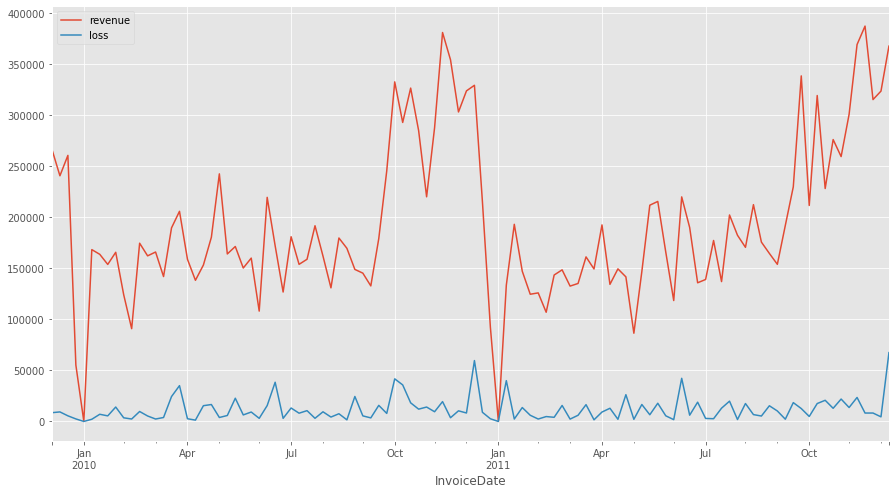

In [28]:
df[['revenue','loss']].resample('W').sum().plot(figsize=(15,8));

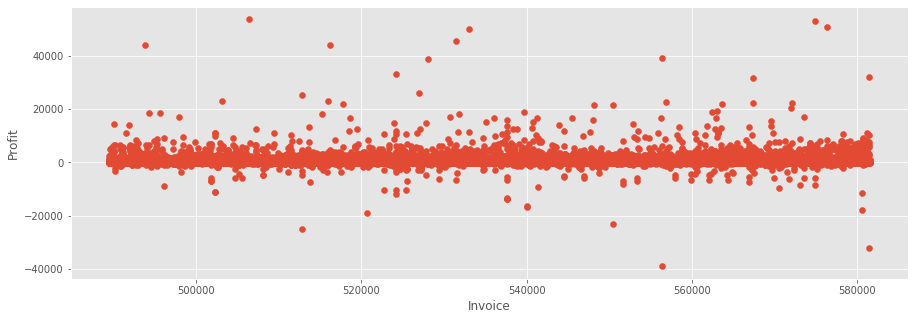

In [268]:
plt.figure(figsize = (15,5))
plt.xlabel('Invoice')
plt.ylabel('Profit')
plt.scatter(df_grp.index,df_grp['profit']);

In [263]:
df_grp.InvoiceDate.isnull().value_counts()

False    47567
True      6061
Name: InvoiceDate, dtype: int64

In [ ]:
plt.figure(figsize = (15,5))
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.scatter(df['InvoiceDate'],df['Quantity']);

In [29]:
df_anonym = df[df['Customer ID'] == 1]
df_user = df[df['Customer ID'] != 1]
df_anonym.shape, df_user.shape

((235151, 14), (797884, 14))

In [30]:
df_anonym.shape[0]/df.shape[0] # 23% anonymous customer - important information because for next machine learning algorithms I should use two dataset separately, one for anonymous customer and second for customer with own ID

0.22763120320221483

##############################################################################################################################

In [31]:
def plot_feat_by_cashfeat(df, feat, cashfeat, top = 20, procent = False):
    
    total_cashfeat = df[cashfeat].sum()
    
    df_grp = (df.groupby(feat)
              .sum()[cashfeat]
              .sort_values(ascending = False)
              .head(top)
             )

    if procent == True:
        df_grp = df_grp.map(lambda x: (x/total_cashfeat)*100)
    
    if cashfeat == 'loss':
        df_grp = -df_grp
        
    
    return df_grp.plot(kind = 'bar', figsize = (15,5))
    
def plot_feat_by_profit(df, feat, top = 20, ascending = False, procent = False ):
    
    total_profit= df['revenue'].sum() - df['loss'].sum()
    
    df_grp = (df.groupby(feat)
              [['revenue','loss']] 
              .sum()       
             )
    
    df_grp['profit'] = df_grp[['revenue','loss']].apply(lambda x: x[0] - x[1] , axis =1 )
    
    df_grp = (df_grp['profit']
              .sort_values(ascending = ascending)
              .head(top)
             )
    
    if procent == True:
        df_grp = df_grp.map(lambda x: (x/total_profit)*100)
    
    return df_grp.plot(kind = 'bar', figsize = (15,5))
    
    

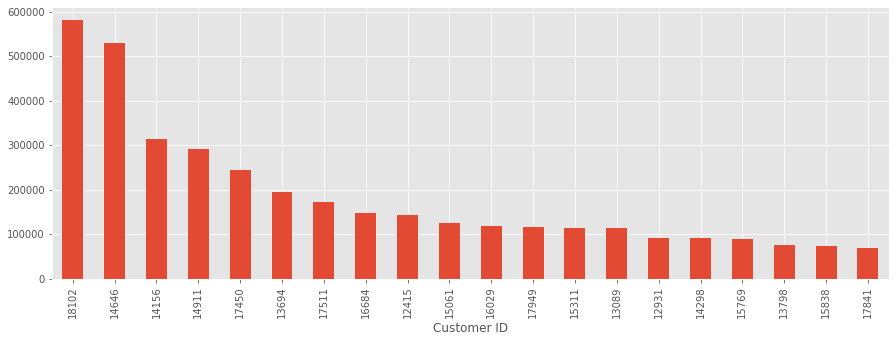

In [32]:
plot_feat_by_cashfeat(df_user,'Customer ID','revenue');

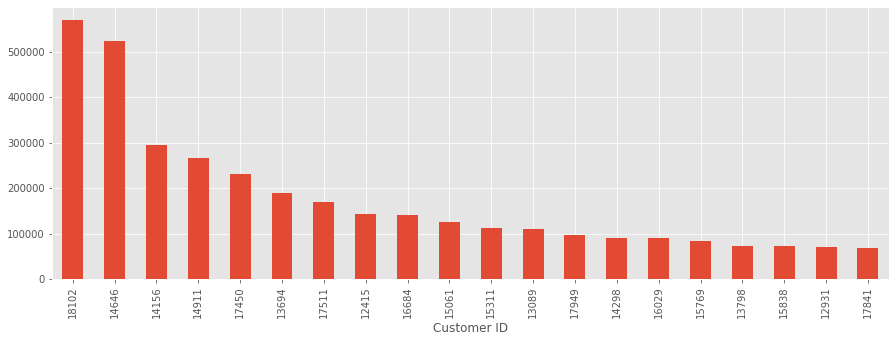

In [33]:
plot_feat_by_profit(df_user,'Customer ID');

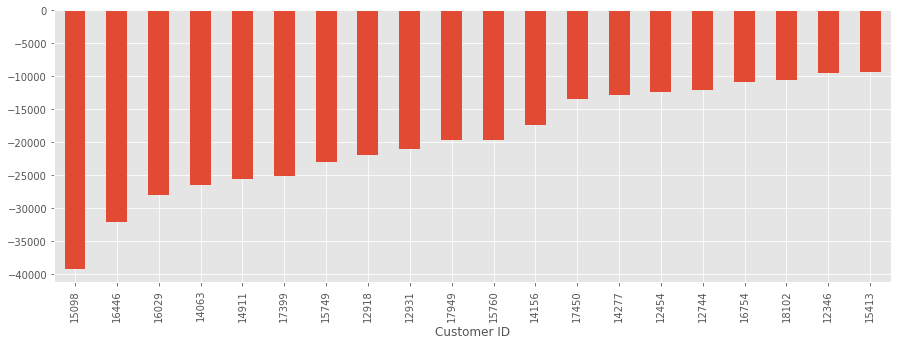

In [34]:
plot_feat_by_cashfeat(df_user,'Customer ID','loss');

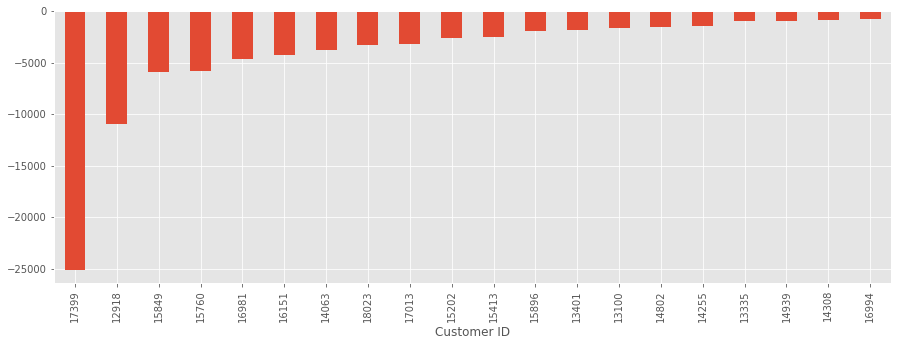

In [35]:
plot_feat_by_profit(df_user,'Customer ID',ascending = True);

##############################################################################################################################

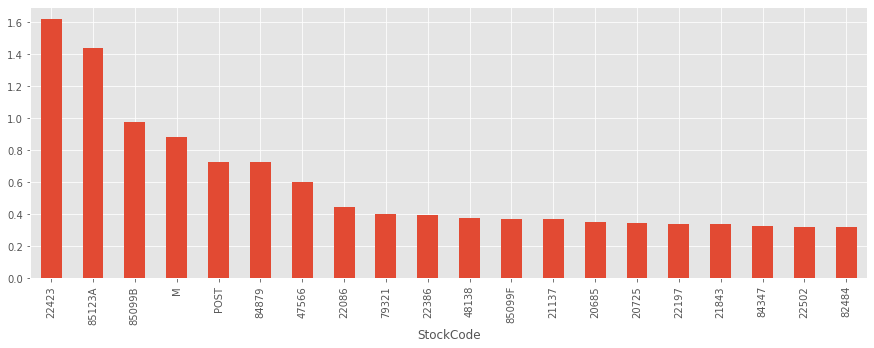

In [36]:
plot_feat_by_cashfeat(df_user,'StockCode','revenue',procent=True);

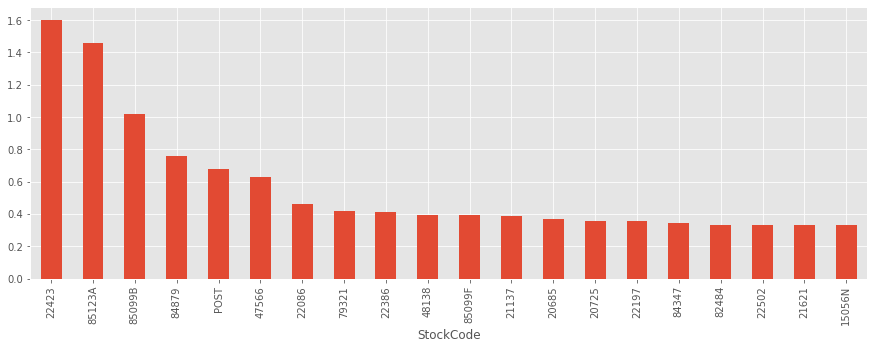

In [37]:
plot_feat_by_profit(df_user,'StockCode',procent = True);

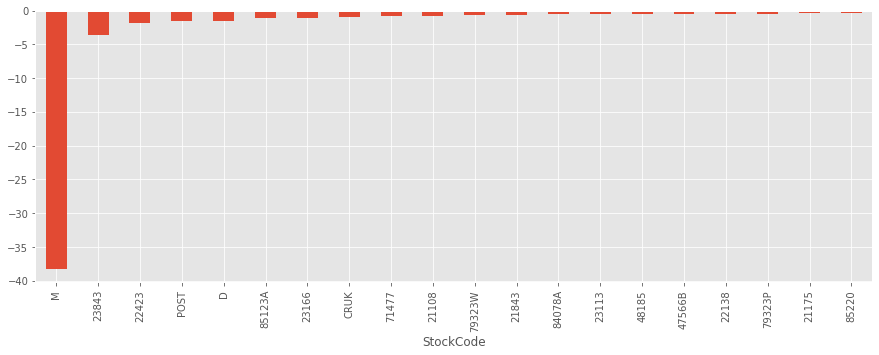

In [38]:
plot_feat_by_cashfeat(df_user,'StockCode','loss', procent = True);

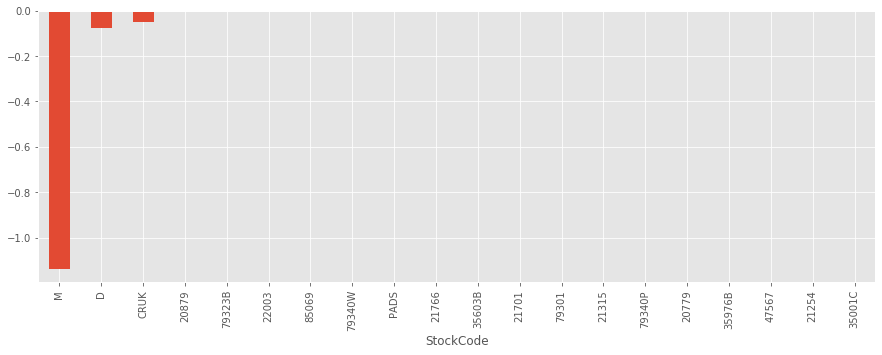

In [39]:
plot_feat_by_profit(df_user,'StockCode',ascending = True, procent = True);

##############################################################################################################################

In [40]:
def plot_castomer_by_profit_cumsum(df,procent):
    
    cast_nuniq = df['Customer ID'].nunique()
    print('{} % customers = {} custoemrs'.format((procent*100), round((cast_nuniq * procent),0)))
    
    df_grp = (df.groupby('Customer ID')
              [['revenue','loss']]
              .sum()
             )
    
    df_grp['profit'] = df_grp[['revenue','loss']].apply(lambda x: x[0]-x[1], axis = 1)
    df_grp = df_grp.sort_values(by = 'profit', ascending = False)
    df_grp['profit_cumsum'] = df_grp['profit'].cumsum()
    
    total_profit = df_grp['profit'].sum()
    
    plt.figure(figsize= (15,5));
    
    df_plot = ((df_grp['profit_cumsum']/total_profit)
               .sort_values(ascending = True)
               .reset_index(drop = True)
              )

    df_plot.plot()

    plt.ylabel('Profit procent');
    plt.xlabel('Number of Customers');
    plt.axvline(ymin = 0, ymax = 1, linewidth=2, x=cast_nuniq*procent ,color = 'green');
    plt.title('{} % of customer generate {} % profit'.format(procent*100, round(df_plot.loc[round((cast_nuniq*procent),0)] *100),1) );

1.0 % customers = 59.0 custoemrs


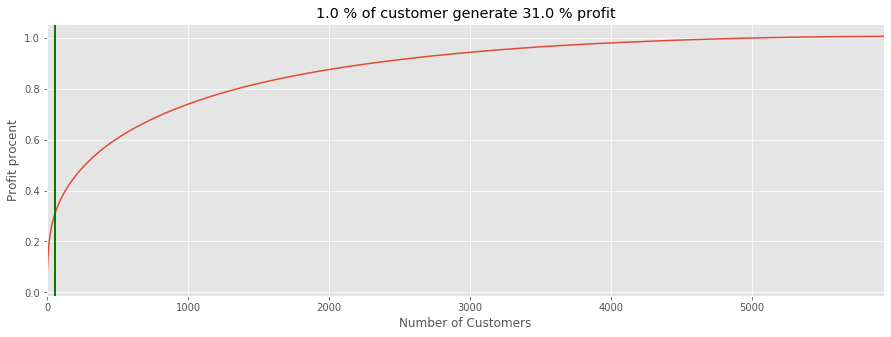

In [41]:
plot_castomer_by_profit_cumsum(df_user,0.01)

10.0 % customers = 594.0 custoemrs


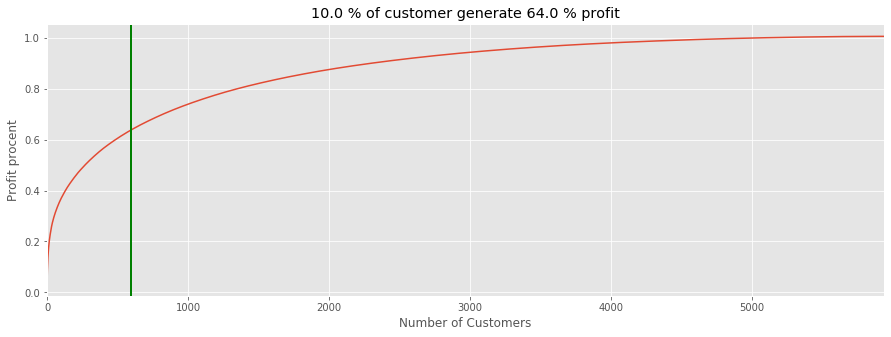

In [42]:
plot_castomer_by_profit_cumsum(df_user,0.1)

20.0 % customers = 1188.0 custoemrs


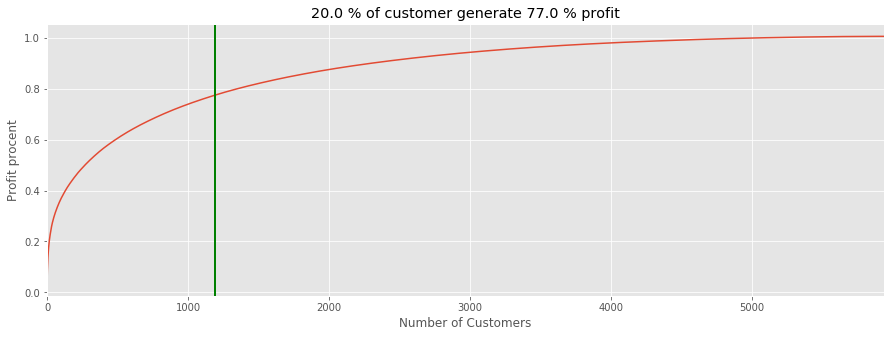

In [43]:
plot_castomer_by_profit_cumsum(df_user,0.2)

##############################################################################################################################

In [44]:
df['Country'].value_counts(normalize = True).head(10) # almost 92% Invoice from UK, during analysis it is important information

United Kingdom    0.917995
EIRE              0.017102
Germany           0.016785
France            0.013576
Netherlands       0.004973
Spain             0.003634
Switzerland       0.003073
Belgium           0.003011
Portugal          0.002447
Australia         0.001830
Name: Country, dtype: float64

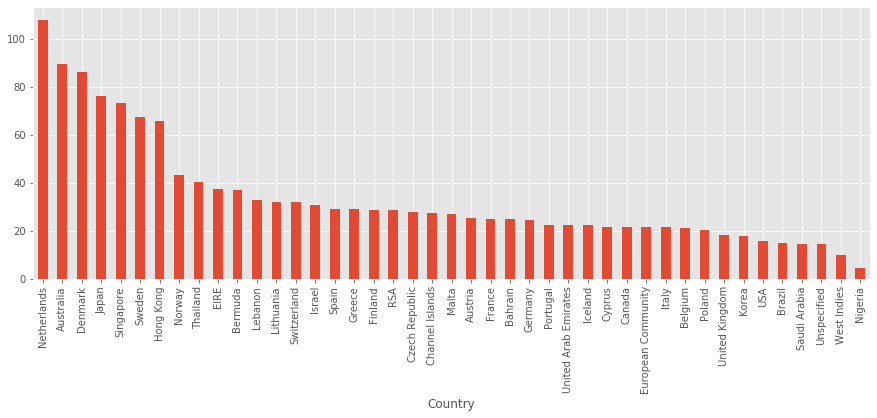

In [45]:
(
    df.groupby('Country')
    ['revenue']
    .mean()
    .sort_values(ascending = False)
    .plot(kind = 'bar', figsize = (15,5))
);


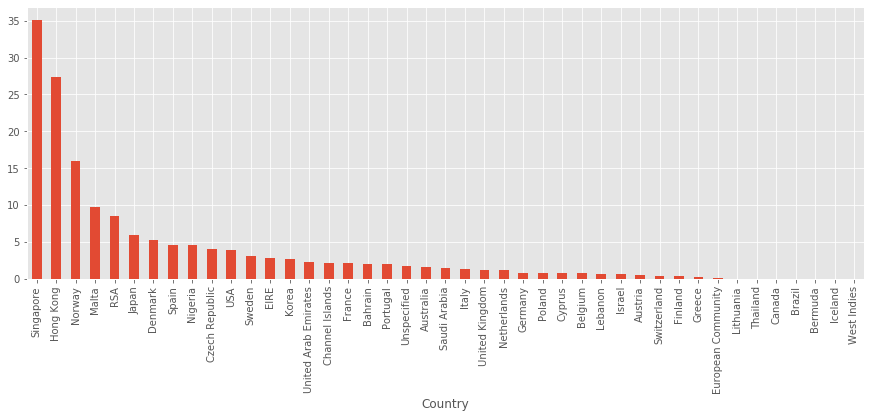

In [46]:
(
    df.groupby('Country')
    ['loss']
    .mean()
    .sort_values(ascending = False)
    .plot(kind = 'bar', figsize = (15,5))
);


##############################################################################################################################

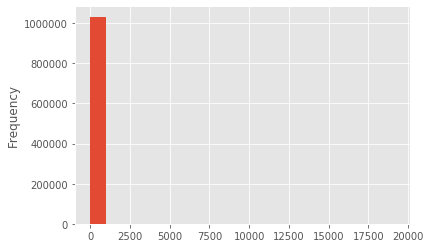

In [47]:
df['Quantity'].plot(kind = 'hist', bins = 20);

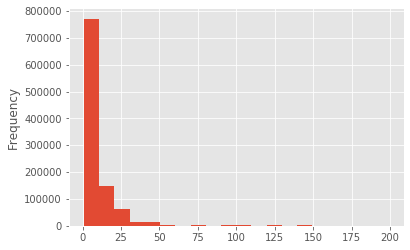

In [48]:
df[df['Quantity']<200]['Quantity'].plot(kind = 'hist', bins = 20);

In [49]:
df[df['Quantity']>8000]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,is_canceled,StockCode_cat,Country_cat,price_total,loss,revenue
InvoiceDate,,,,,,,,,,,,,,
2010-01-21 15:11:00,495194,20993,JAZZ HEARTS MEMO PAD,9312,2010-01-21 15:11:00,0.10,13902,Denmark,False,2126,9,931.20,0.00,931.20
2010-02-15 11:57:00,497946,37410,BLACK AND WHITE PAISLEY FLOWER MUG,19152,2010-02-15 11:57:00,0.10,13902,Denmark,False,594,9,1915.20,0.00,1915.20
2010-02-17 10:51:00,498152,85220,SMALL FAIRY CAKE FRIDGE MAGNETS,9456,2010-02-17 10:51:00,0.30,13902,Denmark,False,1358,9,2836.80,0.00,2836.80
2010-03-17 13:09:00,501534,21099,SET/6 STRAWBERRY PAPER CUPS,12960,2010-03-17 13:09:00,0.10,13902,Denmark,False,125,9,1296.00,0.00,1296.00
2010-03-17 13:09:00,501534,21092,SET/6 STRAWBERRY PAPER PLATES,12480,2010-03-17 13:09:00,0.10,13902,Denmark,False,2059,9,1248.00,0.00,1248.00
2010-03-17 13:09:00,501534,21091,SET/6 WOODLAND PAPER PLATES,12960,2010-03-17 13:09:00,0.10,13902,Denmark,False,129,9,1296.00,0.00,1296.00
2010-03-17 13:09:00,501534,21085,SET/6 WOODLAND PAPER CUPS,12744,2010-03-17 13:09:00,0.10,13902,Denmark,False,126,9,1274.40,0.00,1274.40
2010-03-23 15:36:00,502269,21984,PACK OF 12 PINK PAISLEY TISSUES,10000,2010-03-23 15:36:00,0.25,17940,United Kingdom,False,1666,0,2500.00,0.00,2500.00
2010-03-23 15:36:00,502269,21982,PACK OF 12 SUKI TISSUES,10000,2010-03-23 15:36:00,0.25,17940,United Kingdom,False,1916,0,2500.00,0.00,2500.00


In [50]:
procent = [20,30,50,90,99,99.9]
percentiles = [np.percentile(df['Quantity'],i) for i in procent]

for per,pro in zip(percentiles,procent):
    print('{} % Quantity is less then {}'.format(pro,per))
print('The highest Quantity in dataset: ', df['Quantity'].max())

20 % Quantity is less then 1.0
30 % Quantity is less then 2.0
50 % Quantity is less then 3.0
90 % Quantity is less then 24.0
99 % Quantity is less then 120.0
99.9 % Quantity is less then 600.0
The highest Quantity in dataset:  19152


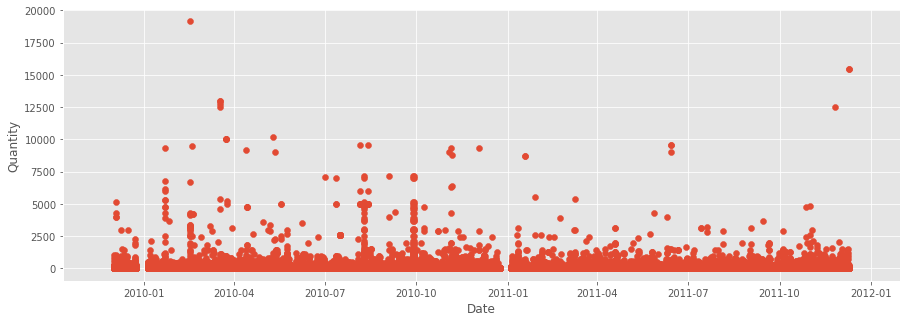

In [230]:
plt.figure(figsize = (15,5))
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.scatter(df['InvoiceDate'],df['Quantity']);

##############################################################################################################################

In [51]:
{
    'number of canceled invoice' : df.groupby('Invoice')['is_canceled'].mean().value_counts()[1],
    'number of invoices': df['Invoice'].nunique(),
    'procent of canceled invoices': round(df.groupby('Invoice')['is_canceled'].mean().value_counts()[1]/df['Invoice'].nunique(),3)* 100,
    'revenue': round(df['revenue'].sum(),0),
    'loss': round(df['loss'].sum(),0),
    'loss/revenue': round((df['loss'].sum()/df['revenue'].sum())*100,1)
}

{'number of canceled invoice': 8292,
 'number of invoices': 53628,
 'procent of canceled invoices': 15.5,
 'revenue': 20430446.0,
 'loss': 1258325.0,
 'loss/revenue': 6.2}

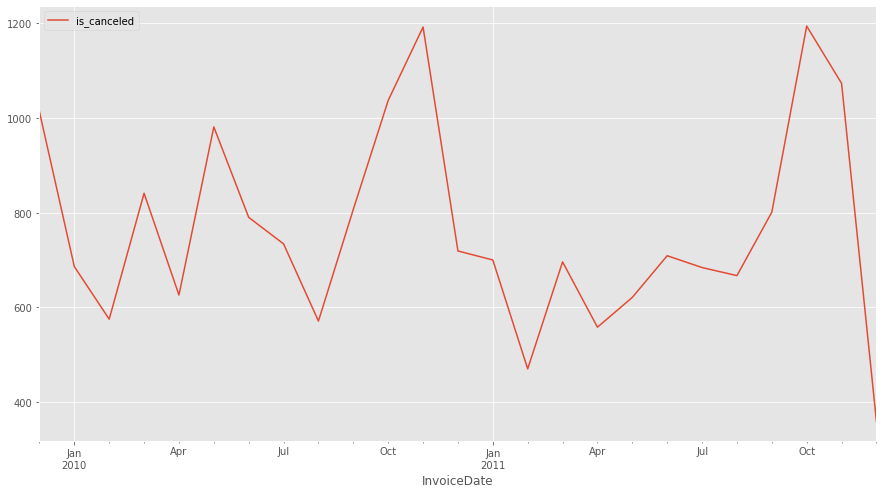

In [52]:
df[['is_canceled']].resample('M').sum().plot(figsize=(15,8));

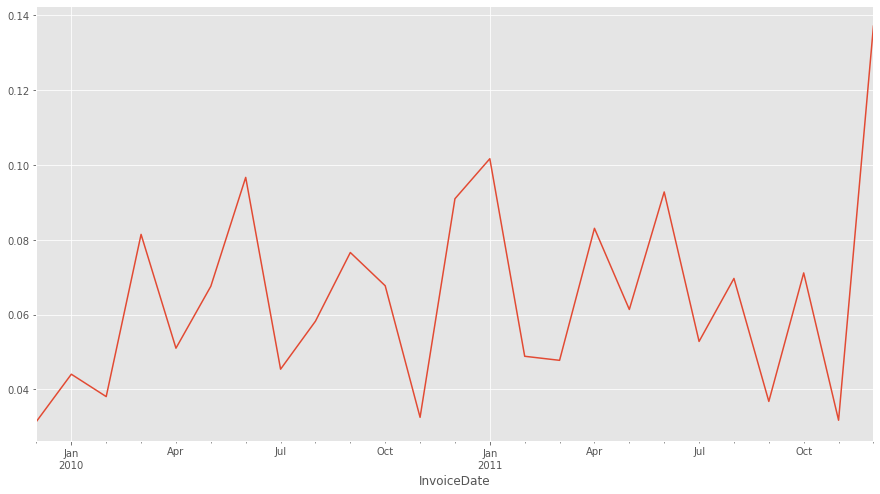

In [60]:
df_plot = df['loss'].resample('M').sum()/df['revenue'].resample('M').sum()
df_plot.plot(figsize=(15,8));

##############################################################################################################################

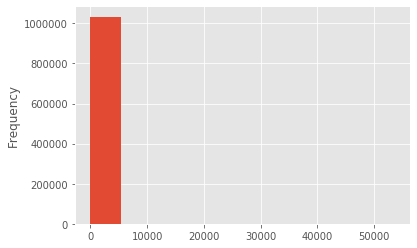

In [59]:
df['Price'].plot(kind = 'hist', bins = 10);

In [55]:
procent = [20,30,50,90,99,99.9]
percentiles = [np.percentile(df['Price'],i) for i in procent]

for per,pro in zip(percentiles,procent):
    print('{} % Price is less then {}'.format(pro,per))
print('The highest Price in dataset: ', df['Price'].max())

20 % Price is less then 0.95
30 % Price is less then 1.25
50 % Price is less then 2.1
90 % Price is less then 7.95
99 % Price is less then 18.0
99.9 % Price is less then 218.92388000002364
The highest Price in dataset:  53594.36


In [56]:
df[df['Price'] > 20000]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,is_canceled,StockCode_cat,Country_cat,price_total,loss,revenue
InvoiceDate,,,,,,,,,,,,,,
2010-04-29 13:36:00,506401,B,Adjust bad debt,1,2010-04-29 13:36:00,53594.36,1,United Kingdom,False,4057,0,53594.36,0.00,53594.36
2010-06-17 16:52:00,512770,M,Manual,1,2010-06-17 16:52:00,25111.09,17399,United Kingdom,True,1232,0,25111.09,25111.09,0.00
2010-06-17 16:53:00,512771,M,Manual,1,2010-06-17 16:53:00,25111.09,1,United Kingdom,False,1232,0,25111.09,0.00,25111.09
2010-07-19 11:24:00,516228,B,Adjust bad debt,1,2010-07-19 11:24:00,44031.79,1,United Kingdom,False,4057,0,44031.79,0.00,44031.79
2010-10-20 12:04:00,528059,B,Adjust bad debt,1,2010-10-20 12:04:00,38925.87,1,United Kingdom,False,4057,0,38925.87,0.00,38925.87
2011-06-10 15:31:00,556445,M,Manual,1,2011-06-10 15:31:00,38970.00,15098,United Kingdom,True,1232,0,38970.00,38970.00,0.00


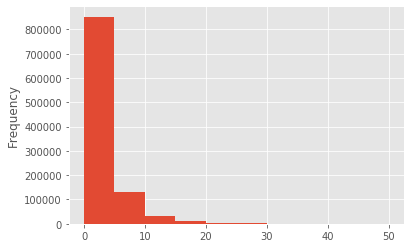

In [58]:
df[df['Price'] < 50]['Price'].plot(kind = 'hist', bins = 10);

##############################################################################################################################

### Feature engineering 
#### Feature engineering was done only on the training set becouse in some cases was used 'is_canceled' columns for example for personalize customer behavior. Data leakage is when information from outside the training dataset is used to create the model. For training was used dataset from 2009-12-01 to 2010-12-01 but for test from 2010-12-01 to 2011-12-09.

In [318]:
import gc
from collections import defaultdict 

pd.options.mode.chained_assignment = None 

In [342]:
df = pd.read_hdf('..\input_data\online_retail.h5')
train = df[df['InvoiceDate'] < '2010-12-01']
test = df[df['InvoiceDate'] >= '2010-12-01']
del test['is_canceled']
gc.collect() #garbage collection

123

In [319]:
def group_to_dict_by_feat(group_key, feat, agg_func=np.sum):
            
    dict_ = train.groupby(group_key)[feat].agg(agg_func).to_dict()
    if 1 in dict_: del dict_[1]
             
    return defaultdict(lambda: None,dict_)

In [343]:
def feat_eng(df, train = True, usage = True):
    
    df['year'] = df['InvoiceDate'].dt.year
    df['month'] = df['InvoiceDate'].dt.month
    df['day'] = df['InvoiceDate'].dt.day
    df['hour'] = df['InvoiceDate'].dt.hour
    df['minute'] = df['InvoiceDate'].dt.minute
    df['dayofweek'] = df['InvoiceDate'].dt.dayofweek
    df['weekofyear'] = df['InvoiceDate'].dt.weekofyear
    df['weekend'] = df['dayofweek'].map(lambda x: int(x in [5,6]) )
    df['dayofyear'] = df['InvoiceDate'].dt.dayofyear
    
    if train == True & usage == True:
        
        df['cnt_canc_customer_id'] = df['Customer ID'].map(group_to_dict_by_feat('Customer ID','is_canceled', agg_func = np.sum))
        df['mean_canc_customer_id'] = df['Customer ID'].map(group_to_dict_by_feat('Customer ID','is_canceled', agg_func = np.mean))
        
        df['cnt_canc_StockCode'] = df['StockCode'].map(group_to_dict_by_feat('StockCode','is_canceled', agg_func = np.sum))
        df['mean_canc_StockCode'] = df['StockCode'].map(group_to_dict_by_feat('StockCode','is_canceled', agg_func = np.mean))
        
        df['cnt_canc_country'] = df['Country'].map(group_to_dict_by_feat('Country','is_canceled', agg_func = np.sum))
        df['mean_canc_country'] = df['Country'].map(group_to_dict_by_feat('Country','is_canceled', agg_func = np.mean))

    del df['Country']
    del df['StockCode']
    
    gc.collect()
    return df

In [344]:
train = feat_eng(train, train = True, usage = True)

In [345]:
train.columns


Index(['Invoice', 'Description', 'Quantity', 'InvoiceDate', 'Price',
       'Customer ID', 'is_canceled', 'StockCode_cat', 'Country_cat', 'year',
       'month', 'day', 'hour', 'minute', 'dayofweek', 'weekofyear', 'weekend',
       'dayofyear', 'cnt_canc_customer_id', 'mean_canc_customer_id',
       'cnt_canc_StockCode', 'mean_canc_StockCode', 'cnt_canc_country',
       'mean_canc_country'],
      dtype='object')